# **Facility location problem**

***facility_location.ipynb***

A facility location problem to select the location of parks over a set of candidate sites that are meant to serve public schools at minimum (average or maximum) distance.

&copy; Copyright 2025 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://community.fico.com/s/contentdocument/06980000002h0i5AAA) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the xpress package
%pip install -q xpress

## Problem description and formulation



There are $n$ public schools in a region. The administration wants to create parks (or gyms, swimming pools, etc.) that can be used by these schools and has $m$ abandoned areas, currently unused, that could be converted for this purpose. The coordinates of both the public schools and the abandoned areas are therefore known. For budget reasons, the administration can only open $p$ parks.

We formulate and solve the problem of choosing the $p$ parks among the abandoned areas in such a way as to minimize one of the following two objective functions:

* the average (i.e. the sum divided by the number of schools) of the distances between each school and the closest (open) park;
* the maximum, calculated on the set of schools, of the distance between the school and the closest park.

The **binary variables $serves_{i,j}$** indicate if school $i \in SCHOOLS$ is served (=1) by the candidate site $j \in SITES$  or not (=0). The **binary variables $build_j$** indicate if a certain candidate site $j$ is selected for creating a park (=1) or not (=0). 

$$\min \sum_{i \in \mathcal{I}} \sum_{j \in \mathcal{J}} dist_{i,j} \cdot serves_{i,j}$$

Subject to:

* Every school must be served by one park:
$$\sum_{j \in SITES} serves_{i,j} = 1, \qquad \forall i \in SCHOOLS$$

* Exactly $n$ parks are built:
$$\sum_{j \in SITES} build_{j} = p, \qquad \forall j \in SITES$$

* Only parks that are built can serve schools:
$$\sum_{i \in SCHOOLS} serves_{i,j} \leq n \cdot build_{j}, \qquad \forall j \in SITES$$

## Data preparation

We start by importing the necessary modules, to then create random coordinates for school and candidate sites to calculate the distances between schools and sites. 

For a different instance, change the value of *rndseed*.

In [1]:
import xpress as xp
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

rndseed = 10
np.random.seed(rndseed)

num_parks = 4    # number of parks to be built
num_schools = 9  # number of schools to be served
num_sites = 11   # number of candidate sites to build parks

SCHOOLS = range(num_schools)  # set of schools
SITES = range(num_sites)      # set of candidate sites

coord_schools = 10 * np.random.random((num_schools, 2))  # x-y coordinates between 0 and 10 (in km)
coord_sites   = 10 * np.random.random((num_sites, 2))

# Create a dictionary with the distances between schools and candidate sites
dist = {(i,j): np.linalg.norm([coord_schools[i] - coord_sites[j]]) for i in SCHOOLS for j in SITES}

Now we define a function to be used for solution visualization using *matplotlib*.

In [2]:
def draw_sol(n, m, prob=None, x=None, y=None):
    """
    Given the variables x and y and their value, display the possible locations for new facilities
    selected by the model and the school-area assignment.
    If x and y are not passed, it displays only the locations of schools and areas.
    """

    mpl.rcParams['figure.figsize'] = (7,7)  # To plot with the right aspect ratio
   
    V = [i for i in range(n + m)]  # Set of nodes

    # Set of edges: condition i<j implies these are EDGES, not arcs, 
    # and therefore they are not directed
    E = []

    # If a solution is provided, use it to create the assignment graph.
    if prob is not None:
        xsol = prob.getSolution(x)
        ysol = prob.getSolution(y)
        E = [(i, n + j) for i in SCHOOLS for j in SITES if xsol[i,j] > 0.5]
        print(E)

    # Create a dictionary with nodes as keys and (x,y) tuples as their values
    coordS = {i:     tuple(coord_schools[i]) for i in SCHOOLS}
    coordA = {n + j: tuple(coord_sites[j])   for j in SITES}

    coord = {**coordS, **coordA}

    node_colS  = {    i: '#5555ff' for i in SCHOOLS}
    node_colA1 = {n + j: '#ff5555' for j in SITES if     y and ysol[j] > 0.5}
    node_colA0 = {n + j: '#a0a0a0' for j in SITES if not y or  ysol[j] < 0.5}
    node_col = {**node_colS, **node_colA1, **node_colA0}
    node_col = [node_col[i] for i in range(n+m)]

    g = nx.Graph()

    g.add_nodes_from(V)
    g.add_edges_from(E)
    

    # Offset the labels
    offset = {node: (coord[node][0] + 0.2, coord[node][1] + 0.2) for node in g.nodes()}
    nx.draw_networkx_labels(g, pos=offset)

    nx.draw_networkx(g, pos=coord, node_color=node_col, node_shape='.', with_labels=False)

Plot the points for schools (blue) and sites (grey) using the previous function.

Schools (blue) and candidate sites for parks (grey):


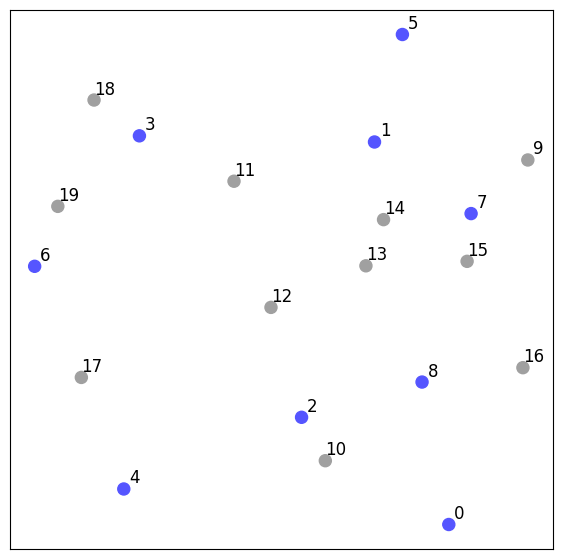

In [3]:
# Pass None as solution to obtain just a map of all schools and of all candidate sites
draw_sol(num_schools,num_sites)

print("Schools (blue) and candidate sites for parks (grey):")
plt.show()

## Model implementation

When passing sets, lists, or range objects to [prob.addVariables()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addVariables.html), the result is a Python dictionary of variables, whose keys are tuples of indices. Variables $serves$ and $build$ are created this way.

The objective and constraints are then created and added to the problem directly by passing the corresponding expression as a list comprehension in the code cell below.

In [ ]:
prob = xp.problem()

serves = prob.addVariables(SCHOOLS, SITES, vartype=xp.binary)
build = prob.addVariables(SITES, vartype=xp.binary)

# Objective function and constraints
prob.setObjective(xp.Sum(dist[i,j] * serves[i,j] for i in SCHOOLS for j in SITES))
    
# Every school must be served by one park
prob.addConstraint(xp.Sum(serves[i,j] for j in SITES) == 1 for i in SCHOOLS)
    
# Exactly n parks are built:
prob.addConstraint(xp.Sum(build[j] for j in SITES) == num_parks)

# Only parks that are built can serve schools
prob.addConstraint(xp.Sum(serves[i,j] for i in SCHOOLS) <= num_schools * build[j] for j in SITES)

prob.optimize()

prob.write("problem.lp")

# Draw solution: open parks and their closest schools
draw_sol(num_schools,num_sites,prob,serves,build)

To consider the **maximum distance** (as opposed to the sum of distances), we model the objective function:

$$
\begin{align*}
\max_{i \in \mathcal{I}} (\sum_{j \in \mathcal{J}} dist_{i,j} . serves_{i,j}) 
\end{align*}
$$

by creating an auxiliary variable $z$, and setting the objective function to ($\min z$) and adding the constraint: 

$$
\begin{align*}
&  \quad z \geq \sum_{j \in \mathcal{J}} dist_{i,j} . serves_{i,j}, \qquad \forall i \in \mathcal{I}  \\
\end{align*}
$$

The new variable is created below, and the new constraints are added to the problem before setting a new objective with [problem.setObjective](), which replaces the old objective function when called again without the *objidx* argument. 

Run the cell below to verify if the optimal solution remains the same for the new objective.

[(0, 10), (1, 9), (2, 10), (3, 11), (4, 17), (5, 9), (6, 17), (7, 9), (8, 10)]


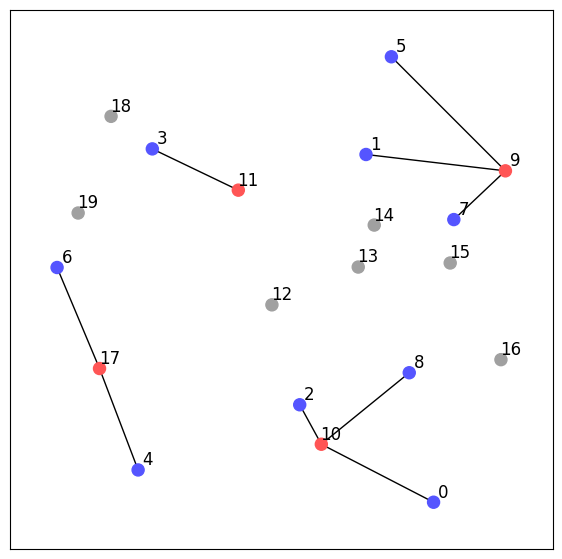

In [6]:
z = prob.addVariable() # add auxiliary variable to the problem

prob.addConstraint(z >= xp.Sum(dist[i,j] * serves[i,j] for j in SITES) for i in SCHOOLS) 

prob.setObjective(z) # replaces the old objective function

prob.controls.outputlog = 0 # Turn off output log for cleaner output

prob.optimize()

# Draw solution: open parks and their closest schools
draw_sol(num_schools,num_sites,prob,serves,build)